# Import Libraries

In [1]:
import pandas as pd

In [85]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import missingno as msno
# from prettytable import PrettyTable


# import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# specify GPU
device = torch.device("mps")


# import warnings
# warnings.filterwarnings('ignore')

# Load Dataset

In [87]:
true_data = pd.read_csv('dataset/True.csv')
fake_data = pd.read_csv('dataset/Fake.csv')

true_data = true_data.sample(n=2000, random_state=42)
fake_data = fake_data.sample(n=2000, random_state=42)


true_data['target'] = ['True']*len(true_data)
fake_data['target'] = ['Fake']*len(fake_data)

df = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

print(df.shape)
df.head()

(4000, 5)


/var/folders/d_/vnpwv0ds1093g2dxlhg7bgrm0000gn/T/ipykernel_40614/2567166384.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])


,title,text,subject,date,target
0,Kansas lawmakers to hash out fiscal 2017 budge...,(Reuters) - A committee of Kansas lawmakers wi...,politicsNews,"March 17, 2017",True
1,Dem Challenger To Paul Ryan Has Raised A Mass...,"Randy Bryce, known as @IronStache on Twitter, ...",News,"June 21, 2017",Fake
2,House passes bill to aid children born into op...,WASHINGTON (Reuters) - The House of Representa...,politicsNews,"May 11, 2016",True
3,Glenn Beck Anchor In Race Attack On Beyoncé F...,"An anchor for Glenn Beck s TV network, The Bla...",News,"February 10, 2016",Fake
4,"CNN, Deutsche Welle could be hit by Russia's '...","MOSCOW (Reuters) - Media outlets such as CNN, ...",worldnews,"November 13, 2017",True


# Data Preparation

In [88]:
df['label'] = pd.get_dummies(df['target'])['Fake']
df.head()

,title,text,subject,date,target,label
0,Kansas lawmakers to hash out fiscal 2017 budge...,(Reuters) - A committee of Kansas lawmakers wi...,politicsNews,"March 17, 2017",True,0
1,Dem Challenger To Paul Ryan Has Raised A Mass...,"Randy Bryce, known as @IronStache on Twitter, ...",News,"June 21, 2017",Fake,1
2,House passes bill to aid children born into op...,WASHINGTON (Reuters) - The House of Representa...,politicsNews,"May 11, 2016",True,0
3,Glenn Beck Anchor In Race Attack On Beyoncé F...,"An anchor for Glenn Beck s TV network, The Bla...",News,"February 10, 2016",Fake,1
4,"CNN, Deutsche Welle could be hit by Russia's '...","MOSCOW (Reuters) - Media outlets such as CNN, ...",worldnews,"November 13, 2017",True,0


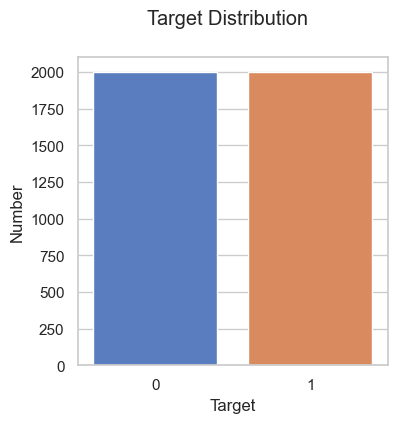

In [89]:
sns.set_theme(style="whitegrid")

chart = 'Target Distribution'

plt.figure(figsize=(4, 4))
plt.suptitle(f'{chart}', y=1)

# plotting countplot based on the target variable
g = sns.countplot(x='label', data=df, palette='muted')
g.set(ylabel='Number', xlabel='Target')

# # annotate the percentage on the chart
total = len(df['target'])
for p in g.patches:
            height = p.get_height()
            percentage = (height / total) * 100
            g.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, height + 200), \
                            ha='center', va='bottom', fontsize=12)

plt.show()

# Modeling

## Train Test Splitting

In [92]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['title'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['target'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

3026    Kremlin, after Kurdish vote, says supports int...
2556     Trump’s Newest Foreign Policy Advisor Is One ...
3597     Trevor Noah Roasts Jeb Bush’s Pathetically De...
1689    Trump tries to move past controversies, says h...
3550    POPE SHAMES AMERICANS From Mexico For Anti-Imm...
                              ...                        
3374     Hurricane Irma threatens luxury Trump properties
2792    LEADING N. CAROLINA NEWSPAPER: Girls Need To A...
720     Saudi-led coalition to reopen Yemen's Hodeidah...
1965    WATCH 8TH Grader DESTROY Disgraced Detroit Cit...
1354     Target Just Made A Major Move That’s Going To...
Name: title, Length: 1200, dtype: object

## Load Pre-trained BERT Model

In [84]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'Number of texts')

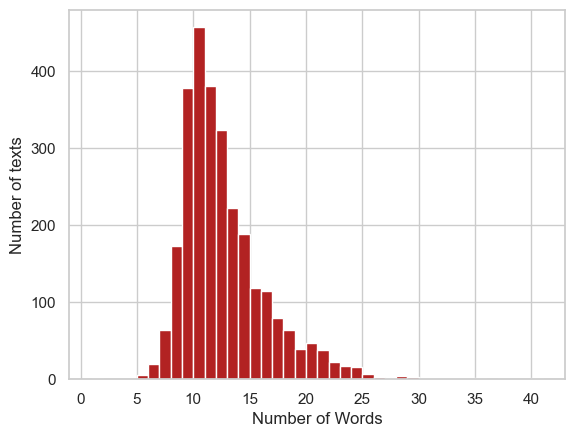

In [70]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [71]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


## 

In [72]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

/Users/crypter70/opt/anaconda3/envs/torch-gpu/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [73]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [74]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [75]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [76]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

/Users/crypter70/opt/anaconda3/envs/torch-gpu/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [77]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    # preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().numpy() 
    
  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      # preds = preds.detach().cpu().numpy()
      preds = preds.detach().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [78]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of     88.

Evaluating...

Training Loss: 0.643
Validation Loss: 0.609

 Epoch 2 / 2
  Batch    50  of     88.

Evaluating...

Training Loss: 0.602
Validation Loss: 0.582


In [38]:
# load weights of best model
# path = 'c1_fakenews_weights.pt'

# model.load_state_dict(torch.load(path))

In [79]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().numpy()
  # preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77       300
           1       0.85      0.56      0.68       300

    accuracy                           0.73       600
   macro avg       0.76      0.73      0.73       600
weighted avg       0.76      0.73      0.73       600



In [40]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().numpy()
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

/Users/crypter70/opt/anaconda3/envs/torch-gpu/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([0, 0, 0, 0])